<a href="https://colab.research.google.com/github/sahilkholkar/PROJECT/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# After running this, you'll be prompted to authenticate your Google account.
# Once authenticated, your Google Drive files will be available under /content/drive/

Mounted at /content/drive


In [ ]:
!pip install numpy==1.25.0  # Jax compatibility is better with more recent NumPy
!pip install --upgrade jax jaxlib # Upgrade Jax and jaxlib

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [ ]:

image_folder = {
    'train': '/content/drive/MyDrive/Datasets/train_images/',
    'test': '/content/drive/MyDrive/Datasets/test_images/'
}
output_folder = '/content/drive/MyDrive/preprocessDatasets/'
df_train = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv')
SEED = 42

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function definitions
def circle_crop(img, sigmaX=10):
    """
    Create a circular crop around the image center.
    """
    img = cv2.imread(img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Crop the image by removing unnecessary gray background.
    """
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark
            return img  # Return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [ ]:
def preprocess_and_save_images(image_folder, output_folder):
    """
    Preprocess images from the specified folder and save them to the output folder.
    """
    # Create output directories if they do not exist
    os.makedirs(output_folder, exist_ok=True)
    # Create subdirectory for train and test images
    train_output_folder = os.path.join(output_folder, "train_images")
    test_output_folder = os.path.join(output_folder, "test_images")
    os.makedirs(train_output_folder, exist_ok=True)
    os.makedirs(test_output_folder, exist_ok=True)

    # Process train images
    for filename in os.listdir(image_folder['train']):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder['train'], filename)
            processed_image = circle_crop(img_path, sigmaX=30)
            cv2.imwrite(os.path.join(train_output_folder, filename), cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

    # Process test images
    for filename in os.listdir(image_folder['test']):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder['test'], filename)
            processed_image = circle_crop(img_path, sigmaX=30)
            cv2.imwrite(os.path.join(test_output_folder, filename), cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

    # Display some processed images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    # Display 10 processed train images
    for i, filename in enumerate(os.listdir(train_output_folder)[:10]):  # Show first 10 processed images
        img = cv2.imread(os.path.join(train_output_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying
        axes[i].imshow(img)
        axes[i].set_title(filename)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

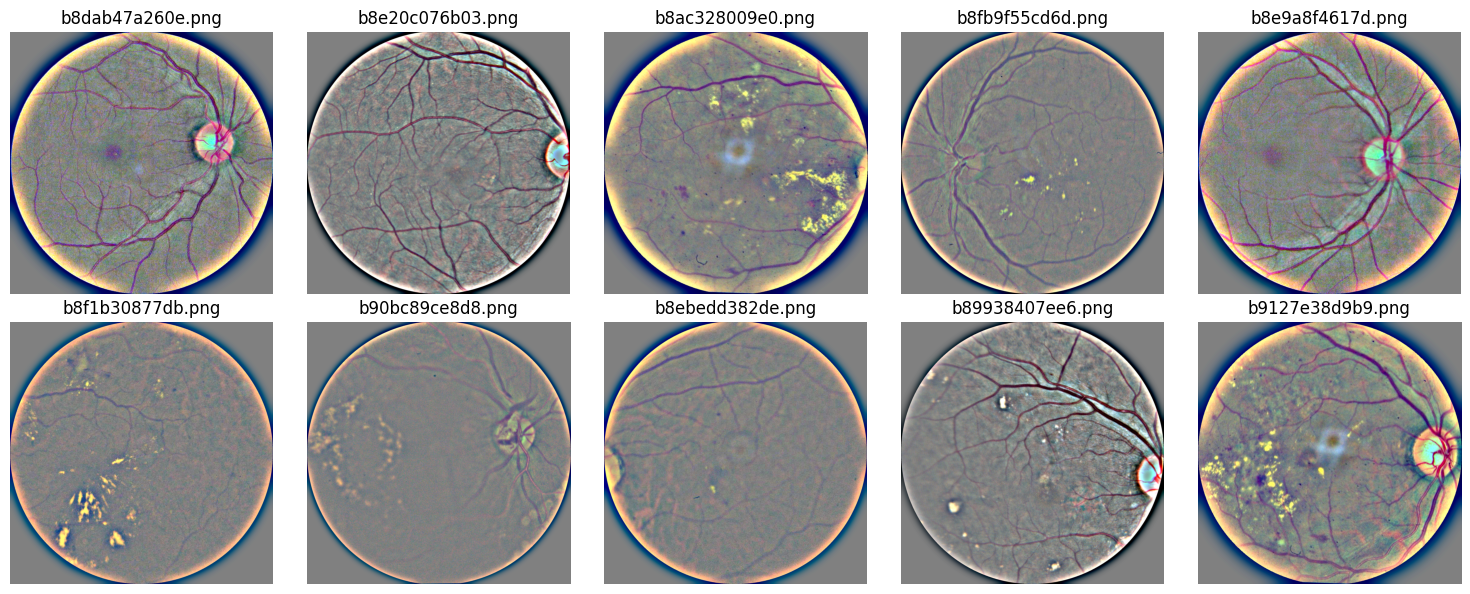

In [ ]:
preprocess_and_save_images(image_folder, output_folder)

CNN starts here

In [ ]:
# Importing all required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
dataset = []
labels = []

In [ ]:
def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(50,50))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    dataset.append(img_array)
    labels.append(str(label))

In [ ]:
train_Data = pd.read_csv("/content/drive/MyDrive/Datasets/train.csv")
train_Data.head()

,id_code,diagnosis
0,012a242ac6ff,1
1,bca2bdc15fc5,1
2,5db895d3f1fc,0
3,2b5bb6d33959,0
4,262ad704319c,1


In [ ]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [ ]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('/content/drive/MyDrive/preprocessDatasets/train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

2929it [12:20,  3.96it/s]


In [ ]:
images = np.array(dataset)
label_arr = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.20,random_state=42)

In [ ]:
import tensorflow as tf # Import TensorFlow
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5) # Use tf.keras.utils.to_categorical
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5) # Use tf.keras.utils.to_categorical

In [ ]:
#CNN MODEL

model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5,activation="softmax"))#5 represent output layer neurons
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,152,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,549 (4.45 MB)

 Trainable params: 1,165,549 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train,y_train,batch_size=64,epochs=30,verbose=1,validation_data=(x_test, y_test))

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.5737 - loss: 0.7894 - val_accuracy: 0.8532 - val_loss: 0.4351
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.8251 - loss: 0.4447 - val_accuracy: 0.8805 - val_loss: 0.3421
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8440 - loss: 0.3713 - val_accuracy: 0.8840 - val_loss: 0.2902
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.8800 - loss: 0.3118 - val_accuracy: 0.8874 - val_loss: 0.3009
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8894 - loss: 0.3169 - val_accuracy: 0.9044 - val_loss: 0.2372
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9016 - loss: 0.2688 - val_accuracy: 0.9147 - val_loss: 0.2009
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9118 - loss: 0.2282 - val_accuracy: 0.9420 - val_loss: 0.1848
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9337 - loss: 0.2121 - val_accuracy: 0

In [ ]:
pred = model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
#printing the accuracy score
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)

0.96


In [ ]:
#printing the report - precision, recall, f1-score, accuracy

report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       291
           1       0.95      0.97      0.96       295

    accuracy                           0.96       586
   macro avg       0.96      0.96      0.96       586
weighted avg       0.96      0.96      0.96       586



In [ ]:
#confusion matrix
conMat = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
print(conMat)

[[277  14]
 [ 10 285]]


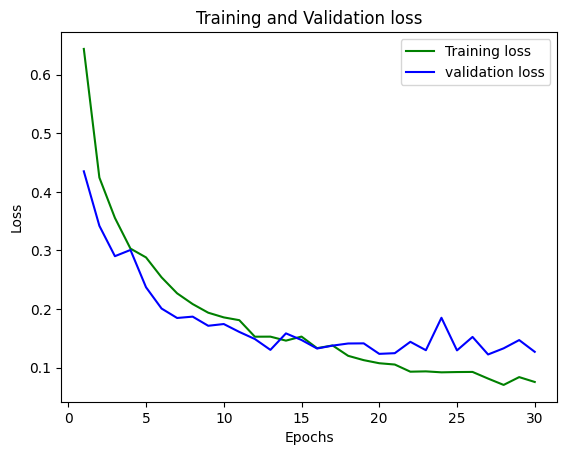

In [ ]:
# loss_train = hist.history['loss']
# loss_val = hist.history['val_loss']
# epochs = range(1,11)
# plt.plot(epochs, loss_train, 'g', label='Training loss')
# plt.plot(epochs, loss_val, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
# The model was trained for 30 epochs, so 'epochs' should match the length of 'loss_train' and 'loss_val'
epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

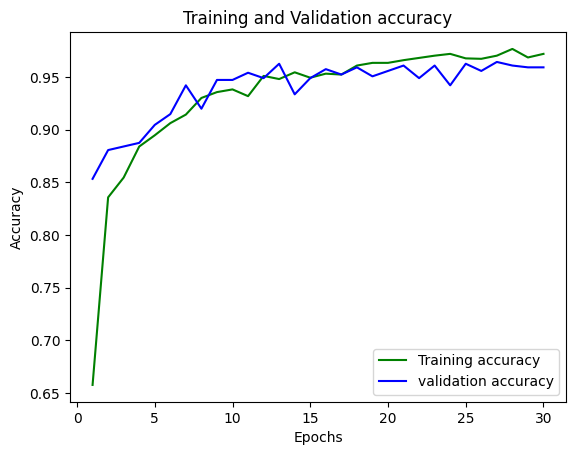

In [ ]:
# loss_train = hist.history['accuracy']
# loss_val = hist.history['val_accuracy']
# epochs = range(1,11)
# plt.plot(epochs, loss_train, 'g', label='Training accuracy')
# plt.plot(epochs, loss_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
# Instead of fixing epochs to 10, make it dynamic to match the length of the training history
epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f"Total images used for training: {len(x_train)}")
# print(f"Total images used for validation: {len(x_val)}")
print(f"Total images used for testing: {len(x_test)}")

Total images used for training: 2343
Total images used for testing: 586


FEDMA

In [ ]:
# -------------------- Imports --------------------
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# -------------------- Load Dataset --------------------
dataset = []
labels = []

def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(50,50))
    img_array = img_res / 255.0
    dataset.append(img_array)
    labels.append(str(label))

train_Data = pd.read_csv("/content/drive/MyDrive/Datasets/train.csv")
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

for id_code, diagnosis in tqdm(zip(id_code_Data, diagnosis_Data)):
    path = os.path.join('/content/drive/MyDrive/preprocessDatasets/train_images', '{}.png'.format(id_code))
    prepare_Images(diagnosis, path)

images = np.array(dataset)
labels = np.array(labels)

x_train_full, x_test, y_train_full, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train_full = to_categorical(y_train_full, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

print(f"Total Train images: {len(x_train_full)}, Test images: {len(x_test)}")

2929it [03:56, 12.39it/s]


Total Train images: 2343, Test images: 586


In [ ]:
# -------------------- Create 5 Clients --------------------
num_clients = 5
client_datasets = []

client_size = len(x_train_full) // num_clients

for i in range(num_clients):
    start = i * client_size
    end = (i+1) * client_size
    client_datasets.append((x_train_full[start:end], y_train_full[start:end]))

In [ ]:
# -------------------- Create CNN Model --------------------
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=2, padding="same", activation="relu", input_shape=(50,50,3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation="softmax"))
    return model

In [ ]:
# -------------------- FedMA Layer Matching --------------------
def match_and_average_neurons(layer_weights_list):
    num_clients = len(layer_weights_list)
    layer_shape = layer_weights_list[0].shape

    if len(layer_shape) == 4:
        axis = -1  # Conv2D filters
    elif len(layer_shape) == 2:
        axis = -1  # Dense layer neurons
    else:
        return np.mean(layer_weights_list, axis=0)  # Bias or others

    num_units = layer_shape[axis]
    matched_units = []

    for unit_idx in range(num_units):
        units = []
        for client_weights in layer_weights_list:
            if len(layer_shape) == 4:
                units.append(client_weights[:,:,:,unit_idx].flatten())
            else:
                units.append(client_weights[:,unit_idx].flatten())
        units = np.stack(units)
        avg_unit = np.mean(units, axis=0)

        if len(layer_shape) == 4:
            matched_units.append(avg_unit.reshape(layer_shape[0], layer_shape[1], layer_shape[2]))
        else:
            matched_units.append(avg_unit)

    if len(layer_shape) == 4:
        aggregated = np.stack(matched_units, axis=3)
    else:
        aggregated = np.stack(matched_units, axis=1)

    return aggregated

def fedma_layerwise_aggregate(local_weights_list):
    num_layers = len(local_weights_list[0])
    aggregated_weights = []
    for layer_idx in range(num_layers):
        layer_weights = [client[layer_idx] for client in local_weights_list]
        aggregated_layer = match_and_average_neurons(layer_weights)
        aggregated_weights.append(aggregated_layer)
    return aggregated_weights

In [ ]:
# -------------------- Federated Training --------------------
communication_rounds = 10
batch_size = 64
epochs_per_round = 10  # Local epochs per round

global_model = create_cnn_model()
global_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_list = []
loss_list = []

for round_num in range(communication_rounds):
    print(f"Communication Round {round_num+1}/{communication_rounds}")

    local_weights = []
    for client_idx, (client_x, client_y) in enumerate(client_datasets):
        local_model = create_cnn_model()
        local_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        local_model.set_weights(global_model.get_weights())

        history = local_model.fit(client_x, client_y, batch_size=batch_size, epochs=epochs_per_round, verbose=0)

        # Collect loss and accuracy from the local training
        local_weights.append(local_model.get_weights())

        # Optionally, you can print the loss after each client's training (if required)
        print(f"Client {client_idx+1} Local Loss: {history.history['loss'][0]}")

    # FedMA Aggregation
    new_global_weights = fedma_layerwise_aggregate(local_weights)
    global_model.set_weights(new_global_weights)

    # Evaluate after aggregation
    scores = global_model.evaluate(x_test, y_test, verbose=0)
    acc_list.append(scores[1])
    loss_list.append(scores[0])

    # Get predictions for confusion matrix accumulation
    y_pred = np.argmax(global_model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Accumulate all predictions and true labels
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_true)

    print(f"Test Accuracy after Round {round_num+1}: {round(scores[1]*100,2)}%")
    print(f"Test Loss after Round {round_num+1}: {round(scores[0], 4)}")

Communication Round 1/10
Client 1 Local Loss: 0.8717300295829773
Client 2 Local Loss: 0.8831920027732849
Client 3 Local Loss: 0.850780725479126
Client 4 Local Loss: 0.8554391860961914
Client 5 Local Loss: 0.8742696046829224
Test Accuracy after Round 1: 86.52%
Test Loss after Round 1: 0.3531
Communication Round 2/10
Client 1 Local Loss: 0.4197978675365448
Client 2 Local Loss: 0.5119094252586365
Client 3 Local Loss: 0.44403523206710815
Client 4 Local Loss: 0.4269545376300812
Client 5 Local Loss: 0.4701351523399353
Test Accuracy after Round 2: 89.93%
Test Loss after Round 2: 0.2471
Communication Round 3/10
Client 1 Local Loss: 0.476707398891449
Client 2 Local Loss: 0.2914247214794159
Client 3 Local Loss: 0.32750412821769714
Client 4 Local Loss: 0.34620144963264465
Client 5 Local Loss: 0.35539478063583374
Test Accuracy after Round 3: 92.83%
Test Loss after Round 3: 0.2011
Communication Round 4/10
Client 1 Local Loss: 0.32782822847366333
Client 2 Local Loss: 0.20009340345859528
Client 3 Loc

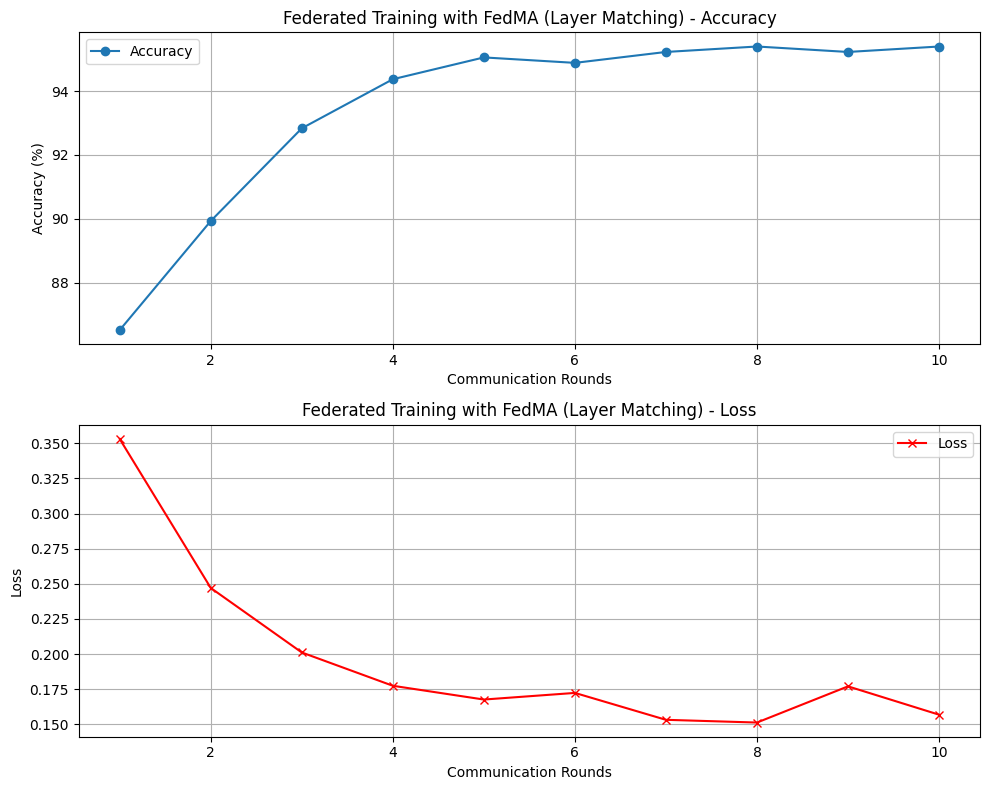

In [ ]:
# -------------------- Plot Accuracy and Loss --------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
ax1.plot(range(1, communication_rounds+1), [acc*100 for acc in acc_list], marker='o', label='Accuracy')
ax1.set_title('Federated Training with FedMA (Layer Matching) - Accuracy')
ax1.set_xlabel('Communication Rounds')
ax1.set_ylabel('Accuracy (%)')
ax1.grid()
ax1.legend()

# Plot Loss
ax2.plot(range(1, communication_rounds+1), loss_list, marker='x', color='red', label='Loss')
ax2.set_title('Federated Training with FedMA (Layer Matching) - Loss')
ax2.set_xlabel('Communication Rounds')
ax2.set_ylabel('Loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# -------------------- Overall Confusion Matrix --------------------
# Compute confusion matrix after all rounds
overall_conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Overall Confusion Matrix after Federated Training')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

NameError: name 'all_true_labels' is not defined